In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import copy
import math
from PIL import Image

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
!unzip -q "/content/drive/MyDrive/Computer Vision Midterm/Fruit_Dataset_Final.zip" -d "/content/"

In [ ]:
# Define the base directory
data_dir = '/content/Fruit_Dataset_Final'

# Define the list of class names based on the previous notebook execution
# The dataset contains fresh and rotten states for apple, banana, grape, mango, orange.
class_names = [
    'fresh_apple', 'fresh_banana', 'fresh_grape', 'fresh_mango', 'fresh_orange',
    'rotten_apple', 'rotten_banana', 'rotten_grape', 'rotten_mango', 'rotten_orange'
]

# Create train and val directories
os.makedirs(os.path.join(data_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(data_dir, 'val'), exist_ok=True)

# Create class subdirectories within train and val
for class_name in class_names:
    os.makedirs(os.path.join(data_dir, 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(data_dir, 'val', class_name), exist_ok=True)

print("Directories created successfully.")

Directories created successfully.


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Define the base directory
data_dir = '/content/Fruit_Dataset_Final'

# Define the list of class names based on the previous notebook execution
class_names = [
    'fresh_apple', 'fresh_banana', 'fresh_grape', 'fresh_mango', 'fresh_orange',
    'rotten_apple', 'rotten_banana', 'rotten_grape', 'rotten_mango', 'rotten_orange'
]

# Define the split ratio (e.g., 80% train, 20% val)
train_ratio = 0.8

# Move images to the new structure
for class_name in class_names:
    original_class_dir = os.path.join(data_dir, class_name)
    if os.path.exists(original_class_dir):
        all_images = [f for f in os.listdir(original_class_dir) if os.path.isfile(os.path.join(original_class_dir, f))]

        # Split images into train and validation sets
        train_images, val_images = train_test_split(all_images, train_size=train_ratio, random_state=42) # Using random_state for reproducibility

        # Move training images
        for img_name in train_images:
            src_path = os.path.join(original_class_dir, img_name)
            dest_path = os.path.join(data_dir, 'train', class_name, img_name)
            shutil.move(src_path, dest_path)

        # Move validation images
        for img_name in val_images:
            src_path = os.path.join(original_class_dir, img_name)
            dest_path = os.path.join(data_dir, 'val', class_name, img_name)
            shutil.move(src_path, dest_path)

        # Optional: Remove the original empty class directory
        os.rmdir(original_class_dir)

print("Images moved and split into train/val directories successfully.")

Images moved and split into train/val directories successfully.


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Re-execute the code from cell_id: 97da74e2 to load the dataset using the corrected structure
data_dir = '/content/Fruit_Dataset_Final'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True if x == 'train' else False, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)
print(dataset_sizes)

['fresh_apple', 'fresh_banana', 'fresh_grape', 'fresh_mango', 'fresh_orange', 'rotten_apple', 'rotten_banana', 'rotten_grape', 'rotten_mango', 'rotten_orange']
{'train': 46507, 'val': 11632}


In [ ]:
def convert_to_days(value, metric):
    """Converts a value and metric to total days."""
    if pd.isna(value):
        return 0
    if metric == 'Weeks':
        return int(value * 7)
    elif metric == 'Days':
        return int(value)
    else:
        return 0

file_path = '/content/FoodKeeper-Data.csv'

# Load the .csv file into a pandas DataFrame
foodkeeper_df = pd.read_csv(file_path, encoding='latin-1')

# Define a label_to_id dictionary
label_to_id = {'apple': 248, 'banana': 251, 'orange': 256, 'grape': 261, 'mango': 265}

# Create an empty dictionary named FOODKEEPER_DB
FOODKEEPER_DB = {}

# Loop through the label_to_id dictionary
for fruit, item_id in label_to_id.items():
    # Find the correct row in the DataFrame
    fruit_data = foodkeeper_df[foodkeeper_df['ID'] == item_id].iloc[0]

    # Extract the required data
    pantry_max = fruit_data['Pantry_Max']
    pantry_metric = fruit_data['Pantry_Metric']
    refrigerate_max = fruit_data['Refrigerate_Max']
    refrigerate_metric = fruit_data['Refrigerate_Metric']
    refrigerate_tips = fruit_data['Refrigerate_tips']

    # Handle NaN tips
    tip = refrigerate_tips if pd.notna(refrigerate_tips) else 'Store properly.'

    # Convert to days
    pantry_days = convert_to_days(pantry_max, pantry_metric)
    fridge_days = convert_to_days(refrigerate_max, refrigerate_metric)

    # Populate the FOODKEEPER_DB
    FOODKEEPER_DB[fruit] = {
        'pantry_days': pantry_days,
        'fridge_days': fridge_days,
        'fridge_tip': tip
    }

# Print the FOODKEEPER_DB dictionary
print(FOODKEEPER_DB)

{'apple': {'pantry_days': 0, 'fridge_days': 0, 'fridge_tip': 'Store properly.'}, 'banana': {'pantry_days': 0, 'fridge_days': 3, 'fridge_tip': 'Timeline for refrigerator applies to ripe fruit; skin will blacken.'}, 'orange': {'pantry_days': 0, 'fridge_days': 0, 'fridge_tip': 'Store properly.'}, 'grape': {'pantry_days': 0, 'fridge_days': 0, 'fridge_tip': 'Store properly.'}, 'mango': {'pantry_days': 0, 'fridge_days': 0, 'fridge_tip': 'Store properly.'}}


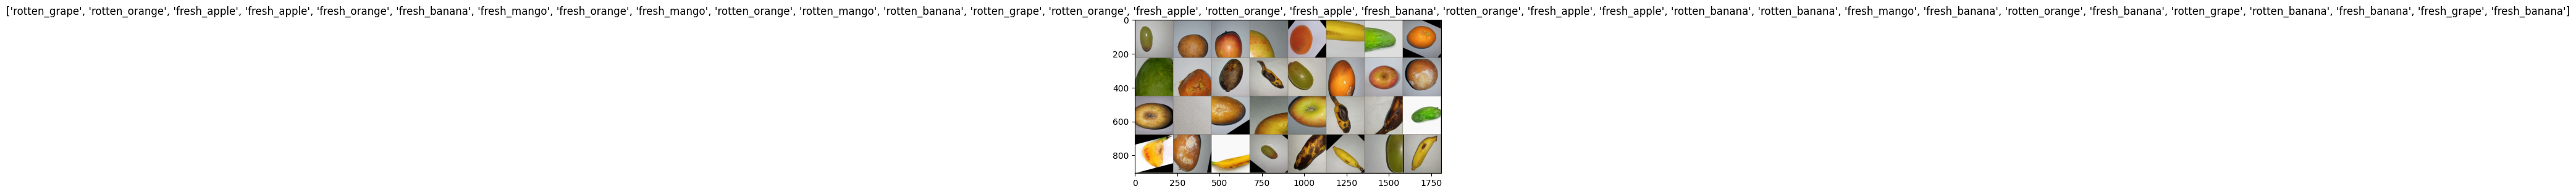

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Freeze all layers except the final one
for param in model.parameters():
    param.requires_grad = False

# Get the number of input features for the final layer
num_ftrs = model.fc.in_features

# Replace the final layer with a new one
model.fc = nn.Linear(num_ftrs, len(class_names))

# Print class names and the number of classes
print("Class names:", class_names)
print("Number of classes:", len(class_names))

# Move the model to the device
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 543MB/s]


Class names: ['fresh_apple', 'fresh_banana', 'fresh_grape', 'fresh_mango', 'fresh_orange', 'rotten_apple', 'rotten_banana', 'rotten_grape', 'rotten_mango', 'rotten_orange']
Number of classes: 10


In [ ]:
criterion = nn.CrossEntropyLoss()

# Only optimize parameters in the new, unfrozen final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001) # You might want to adjust the learning rate (lr)

In [ ]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it has better validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
num_epochs = 1
model = train_model(model, criterion, optimizer, dataloaders, device, num_epochs=num_epochs)

# The train_model function already loads the best weights before returning the model,
# but you can explicitly load them again if needed:
# model.load_state_dict(best_model_wts)

Epoch 0/0
----------
train Loss: 0.3157 Acc: 0.9184
val Loss: 0.1012 Acc: 0.9735

Training complete in 15m 55s
Best val Acc: 0.9735


In [ ]:
def predict_freshness(image_path, model, storage_type, class_names):
    """
    Predicts the freshness of an image and provides storage information.

    Args:
        image_path (str): Path to the image file.
        model (torch.nn.Module): Trained PyTorch model.
        storage_type (str): 'pantry' or 'fridge'.
        class_names (list): List of class names.
    """
    # 1. Open the image
    image = Image.open(image_path)

    # 2. Apply the 'val' transformation and add a batch dimension
    image = data_transforms['val'](image).unsqueeze(0)

    # 3. Move the image tensor to the device
    image = image.to(device)

    # 4. Run the image through the model to get the output logits
    with torch.no_grad():
        outputs = model(image)

    # 5. Apply torch.softmax to get probabilities
    probabilities = torch.softmax(outputs, dim=1)

    # 6. Find the highest probability (top_p) and its index (top_i)
    top_p, top_i = probabilities.topk(1, dim=1)

    # 7. Get the predicted_class_name
    predicted_class_name = class_names[top_i.item()]

    # 8. Parse the predicted class name
    parts = predicted_class_name.split('_')
    state = parts[0].capitalize() # 'Fresh' or 'Rotten'
    fruit = parts[1]

    # 9. Query the FOODKEEPER_DB
    if fruit in FOODKEEPER_DB:
        total_days = FOODKEEPER_DB[fruit][f'{storage_type}_days']
        # Retrieve tip based on storage type if available, otherwise use fridge tip or default
        tip = FOODKEEPER_DB[fruit].get(f'{storage_type}_tip', FOODKEEPER_DB[fruit].get('fridge_tip', 'Store properly.'))
    else:
        total_days = 0
        tip = "Information not available for this fruit."

    # 10. Calculate the "best guess" for remaining days based on predicted state and confidence
    if state == 'Rotten':
        remaining_days_guess = 0
        remaining_days_text = "0 (Spoiled)"
    else:
        # Calculate "best guess" by scaling total days by confidence
        remaining_days_guess = total_days * top_p.item()
        remaining_days_text = f"{math.ceil(remaining_days_guess)} (Best guess based on confidence)"


    # 11. Print a formatted report
    print("-" * 30)
    print(f"Fruit: {fruit.capitalize()}")
    print(f"Status: {state}")
    print(f"Confidence: {top_p.item():.2f}")
    print(f"Remaining Days: {remaining_days_text}")
    print(f"Storage Tip: {tip}")
    print("-" * 30)

In [ ]:
# Example usage of the predict_freshness function:

# Find a sample fresh apple image path from the validation set
fresh_apple_path = "/content/Fruit_Dataset_Final/val/fresh_apple/" + os.listdir("/content/Fruit_Dataset_Final/val/fresh_apple/")[0]

# Call the predict_freshness function for the fresh apple with 'fridge' storage
print("Predicting freshness for a fresh apple in the fridge:")
predict_freshness(fresh_apple_path, model, 'fridge', class_names)

# Find a sample rotten banana image path from the validation set
rotten_banana_path = "/content/Fruit_Dataset_Final/val/rotten_banana/" + os.listdir("/content/Fruit_Dataset_Final/val/rotten_banana/")[0]

# Call the predict_freshness function for the rotten banana with 'pantry' storage
print("\nPredicting freshness for a rotten banana in the pantry:")
predict_freshness(rotten_banana_path, model, 'pantry', class_names)

Predicting freshness for a fresh apple in the fridge:
------------------------------
Fruit: Apple
Status: Fresh
Confidence: 0.99
Remaining Days: 0 (Best guess based on confidence)
Storage Tip: Store properly.
------------------------------

Predicting freshness for a rotten banana in the pantry:
------------------------------
Fruit: Banana
Status: Rotten
Confidence: 1.00
Remaining Days: 0 (Spoiled)
Storage Tip: Timeline for refrigerator applies to ripe fruit; skin will blacken.
------------------------------
